In [73]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Tuple, Optional, Dict
from sklearn.impute import SimpleImputer

# Load required libraries and set display options
pd.set_option('display.max_columns', None)
# Set up visualization settings
plt.style.use('seaborn')
sns.set_palette("husl")

/var/folders/q0/7qtgvcgn1sxg_2jgqvvm73wr0000gn/T/ipykernel_15879/904339711.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [74]:
sys.path.append(os.path.abspath('../src'))
path_to_py = os.path.abspath('../src')

In [75]:
data_train = pd.read_csv(os.path.join(path_to_py, "data", "training_loan_data.csv"), skiprows=1)
display(data_train.head())

,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,10000001,11983056.0,7550,36 months,16.24%,3 years,RENT,28000.0,NaN,debt_consolidation,100.0,96.0,8.40,0.0,17.0,72%,4000.0,NaN,3828.953801,5759.0,1,99,0.0
1,10000002,12002921.0,27050,36 months,10.99%,10+ years,OWN,55000.0,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,25.0,53.9,22.87,0.0,8.0,61.20%,35700.0,NaN,34359.940730,114834.0,1,353,0.0
2,10000003,11983096.0,12000,36 months,10.99%,4 years,RENT,60000.0,Borrower added on 12/31/13 > I would like to...,debt_consolidation,0.0,15.9,4.62,1.0,3.0,24%,18100.0,NaN,16416.617760,7137.0,1,157,0.0
3,10000004,12003142.0,28000,36 months,7.62%,5 years,MORTGAGE,325000.0,NaN,debt_consolidation,16.7,67.1,18.55,1.0,3.0,54.60%,42200.0,NaN,38014.149760,799592.0,1,365,0.0
4,10000005,11993233.0,12000,36 months,13.53%,10+ years,RENT,40000.0,NaN,debt_consolidation,33.3,79.6,16.94,0.0,17.0,68.80%,7000.0,53.0,6471.462236,13605.0,1,157,0.0


In [76]:
data = data_train.copy()

In [77]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'term', 'int_rate', 'emp_length',
       'home_ownership', 'annual_inc', 'desc', 'purpose', 'percent_bc_gt_75',
       'bc_util', 'dti', 'inq_last_6mths', 'mths_since_recent_inq',
       'revol_util', 'total_bc_limit', 'mths_since_last_major_derog',
       'tot_hi_cred_lim', 'tot_cur_bal', 'application_approved_flag',
       'internal_score', 'bad_flag'],
      dtype='object')

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199121 entries, 0 to 199120
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           199121 non-null  int64  
 1   member_id                    189457 non-null  float64
 2   loan_amnt                    199121 non-null  int64  
 3   term                         189457 non-null  object 
 4   int_rate                     189457 non-null  object 
 5   emp_length                   181531 non-null  object 
 6   home_ownership               189457 non-null  object 
 7   annual_inc                   189457 non-null  float64
 8   desc                         82004 non-null   object 
 9   purpose                      189457 non-null  object 
 10  percent_bc_gt_75             180419 non-null  float64
 11  bc_util                      180333 non-null  float64
 12  dti                          189457 non-null  float64
 13 

**Observations**:
- term, home_ownership, and purpose are all categorical variables **Fix**: Convert them to categorical data type to save memory and make categorical operations more efficient
- int_rate and revol_util are percentage columns **Fix**: Convert from string percentages to proper decimals to allow for proper numerical operations and comparisons
- emp_length is an ordinal feature **Fix**: Convert to numerical on a scale of 0-10 according to the data dictionary

In [79]:
# Fix Categorical Columns
print("\n=== Fixing Categorical Columns ===")

# term: Convert to categorical
print("\nterm unique values:")
print(data['term'].unique())
data['term'] = data['term'].astype('category')

# home_ownership: Convert to categorical
print("\nhome_ownership unique values:")
print(data['home_ownership'].unique())
data['home_ownership'] = data['home_ownership'].astype('category')

# purpose: Convert to categorical
print("\npurpose unique values:")
print(data['purpose'].unique())
data['purpose'] = data['purpose'].astype('category')


=== Fixing Categorical Columns ===

term unique values:
[' 36 months' ' 60 months' nan]

home_ownership unique values:
['RENT' 'OWN' 'MORTGAGE' 'NONE' 'OTHER' nan]

purpose unique values:
['debt_consolidation' 'home_improvement' 'credit_card' 'other'
 'major_purchase' 'small_business' 'house' 'moving' 'medical' 'car'
 'vacation' 'renewable_energy' 'wedding' nan]


In [80]:
# Fix Percentage Columns
print("=== Fixing Percentage Columns ===")

# int_rate: Currently object, should be float
print("\nint_rate before conversion:")
print(data['int_rate'].head())
data['int_rate'] = data['int_rate'].str.rstrip('%').astype('float')

print("\nint_rate after conversion:")
print(data['int_rate'].head())

# revol_util: Currently object, should be float
print("\nrevol_util before conversion:")
print(data['revol_util'].head())
data['revol_util'] = data['revol_util'].str.rstrip('%').astype('float')

print("\nrevol_util after conversion:")
print(data['revol_util'].head())

=== Fixing Percentage Columns ===

int_rate before conversion:
0    16.24%
1    10.99%
2    10.99%
3     7.62%
4    13.53%
Name: int_rate, dtype: object

int_rate after conversion:
0    16.24
1    10.99
2    10.99
3     7.62
4    13.53
Name: int_rate, dtype: float64

revol_util before conversion:
0       72%
1    61.20%
2       24%
3    54.60%
4    68.80%
Name: revol_util, dtype: object

revol_util after conversion:
0    72.0
1    61.2
2    24.0
3    54.6
4    68.8
Name: revol_util, dtype: float64


In [81]:
# Fix emp_length
print("\n=== Fixing Employment Length ===")
print("\nemp_length unique values before conversion:")
print(data['emp_length'].unique())

def clean_emp_length(value: str) -> int:
    """Convert employment length to years (0-10)."""
    if pd.isna(value):
        return np.nan
    value = str(value).lower().strip()
    if '10+' in value:
        return 10
    elif '< 1' in value:
        return 0
    return int(value.split()[0])

data['emp_length'] = data['emp_length'].apply(clean_emp_length)

print("\nemp_length unique values after conversion:")
print(sorted(data['emp_length'].unique()))


=== Fixing Employment Length ===

emp_length unique values before conversion:
['3 years' '10+ years' '4 years' '5 years' '2 years' '7 years' '6 years'
 '1 year' '9 years' '< 1 year' '8 years' nan]

emp_length unique values after conversion:
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]


In [82]:
# Verify Binary Columns
print("\n=== Verifying Binary Columns ===")
print("\napplication_approved_flag unique values:")
print(data['application_approved_flag'].unique())
print("\nbad_flag unique values:")
print(data['bad_flag'].unique())


=== Verifying Binary Columns ===

application_approved_flag unique values:
[1]

bad_flag unique values:
[ 0.  1. nan]


In [83]:
# Final Data Types Check
print("\n=== Final Data Types ===")
print(data.dtypes)


=== Final Data Types ===
id                                int64
member_id                       float64
loan_amnt                         int64
term                           category
int_rate                        float64
emp_length                      float64
home_ownership                 category
annual_inc                      float64
desc                             object
purpose                        category
percent_bc_gt_75                float64
bc_util                         float64
dti                             float64
inq_last_6mths                  float64
mths_since_recent_inq           float64
revol_util                      float64
total_bc_limit                  float64
mths_since_last_major_derog     float64
tot_hi_cred_lim                 float64
tot_cur_bal                     float64
application_approved_flag         int64
internal_score                    int64
bad_flag                        float64
dtype: object


- Now that we have converted all features to their appropriate data types, let's next handle the missing values

### Overall Missing Value Analysis

In [84]:
# Overall Missing Value Analysis
print("=== Missing Value Analysis ===")
missing_stats = pd.DataFrame({
    'Missing Count': data.isnull().sum(),
    'Missing Percentage': (data.isnull().sum() / len(data) * 100).round(2)
}).sort_values('Missing Percentage', ascending=False)
print(missing_stats)

=== Missing Value Analysis ===
                             Missing Count  Missing Percentage
mths_since_last_major_derog         166372               83.55
desc                                117117               58.82
mths_since_recent_inq                37649               18.91
tot_cur_bal                          37405               18.79
bc_util                              18788                9.44
percent_bc_gt_75                     18702                9.39
emp_length                           17590                8.83
tot_hi_cred_lim                      17159                8.62
total_bc_limit                       17159                8.62
revol_util                            9791                4.92
dti                                   9664                4.85
inq_last_6mths                        9664                4.85
bad_flag                              9664                4.85
member_id                             9664                4.85
purpose                 

**Observation**:
Let's first drop the unnecessary columns like the id and member_id. application_approved_flag is not required as it has only '1' as value throughout and no missing values and doesn't provide any discriminatory information. Then, the bad_flag feature which is our target variable has missing values. There are many other features with the same number of missing values suggesting that there might be missing values whenever the target variable is null. So, first removing rows where target variable is null might remove most of the missing values in the data.

In [85]:
# 1. Drop unnecessary columns
columns_to_drop = ['id', 'member_id', 'application_approved_flag']
data = data.drop(columns=columns_to_drop)
print("\nShape after dropping unnecessary columns:", data.shape)

# 2. Drop rows where target variable (bad_flag) is null
data = data.dropna(subset=['bad_flag'])
print("\nShape after dropping rows with null target:", data.shape)

# 3. Verify the impact on other features
print("\n=== Missing Value Analysis After Cleaning ===")
missing_stats = pd.DataFrame({
    'Missing Count': data.isnull().sum(),
    'Missing Percentage': (data.isnull().sum() / len(data) * 100).round(2)
}).sort_values('Missing Percentage', ascending=False)
print(missing_stats)

# 4. Verify if the features that had same missing count as bad_flag are now complete
common_null_features = ['dti', 'inq_last_6mths', 'purpose', 'annual_inc', 
                       'home_ownership', 'int_rate', 'term']
print("\n=== Verification of Previously Correlated Nulls ===")
print(data[common_null_features].isnull().sum())

# 5. Check remaining null patterns
print("\n=== Remaining Null Patterns ===")
# Count number of null values per row
null_counts = data.isnull().sum(axis=1)
print("\nRows with null values distribution:")
print(null_counts.value_counts().sort_index())

print("\nCleaning complete. Ready for next steps.")


Shape after dropping unnecessary columns: (199121, 20)

Shape after dropping rows with null target: (189457, 20)

=== Missing Value Analysis After Cleaning ===
                             Missing Count  Missing Percentage
mths_since_last_major_derog         156708               82.71
desc                                107453               56.72
mths_since_recent_inq                27985               14.77
tot_cur_bal                          27741               14.64
bc_util                               9124                4.82
percent_bc_gt_75                      9038                4.77
emp_length                            7926                4.18
tot_hi_cred_lim                       7495                3.96
total_bc_limit                        7495                3.96
revol_util                             127                0.07
loan_amnt                                0                0.00
internal_score                           0                0.00
dti                 

- Now, the missing values significantly reduced. 
- There are two features with the same number of missing values - total_hi_cred_lim and total_bc_limit which could mean that they could be missing together and might indicate cases where applicants have no credit history. They could be related to specific loan purposes or applicant profiles.
- bc_util and percent_bc_gt_75 also show very similar missing patterns (9,124 and 9,038 missing values respectively), which makes sense because both are related to bankcard utilization and so missing values likely indicate no bankcard history

=== Credit Features Missing Pattern ===

Missing value correlation matrix:
                  bc_util  percent_bc_gt_75  revol_util  total_bc_limit  \
bc_util             1.000             0.995       0.115           0.902   
percent_bc_gt_75    0.995             1.000       0.099           0.907   
revol_util          0.115             0.099       1.000           0.007   
total_bc_limit      0.902             0.907       0.007           1.000   
tot_hi_cred_lim     0.902             0.907       0.007           1.000   
tot_cur_bal         0.449             0.451       0.007           0.490   

                  tot_hi_cred_lim  tot_cur_bal  
bc_util                     0.902        0.449  
percent_bc_gt_75            0.907        0.451  
revol_util                  0.007        0.007  
total_bc_limit              1.000        0.490  
tot_hi_cred_lim             1.000        0.490  
tot_cur_bal                 0.490        1.000  


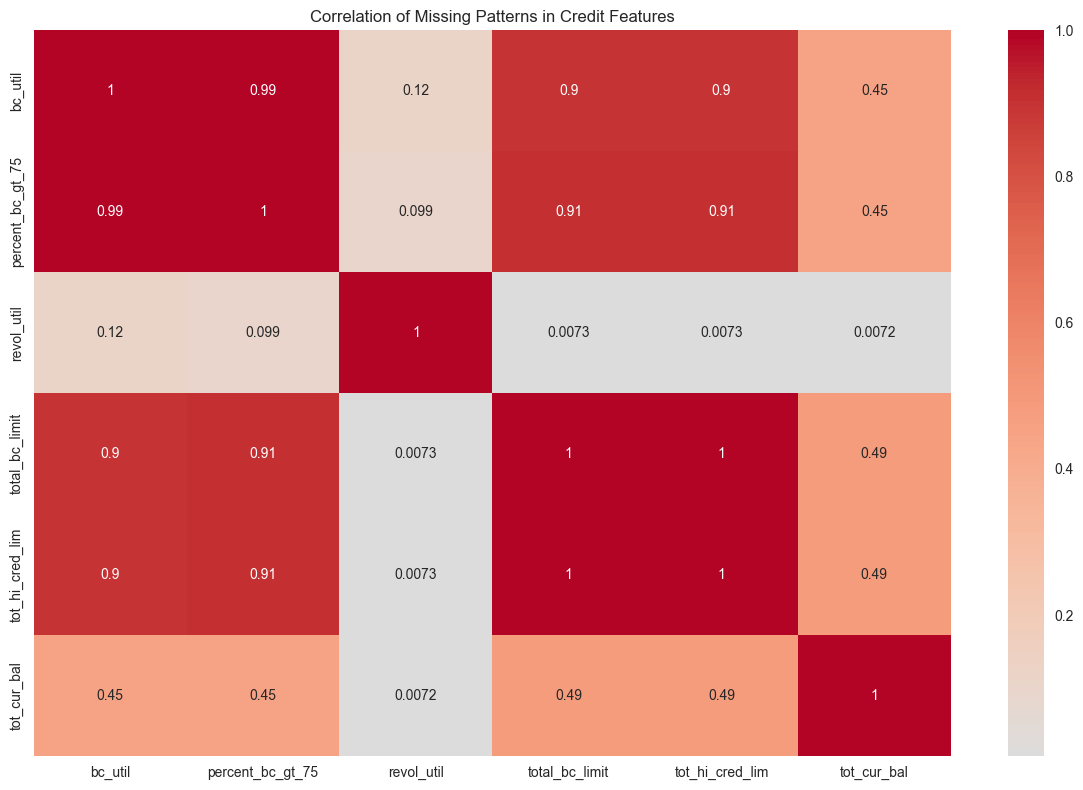


=== Value Correlations (Complete Cases) ===
                  bc_util  percent_bc_gt_75  revol_util  total_bc_limit  \
bc_util             1.000             0.830       0.835          -0.291   
percent_bc_gt_75    0.830             1.000       0.701          -0.250   
revol_util          0.835             0.701       1.000          -0.206   
total_bc_limit     -0.291            -0.250      -0.206           1.000   
tot_hi_cred_lim    -0.290            -0.250      -0.205           0.996   
tot_cur_bal         0.002            -0.011       0.044           0.306   

                  tot_hi_cred_lim  tot_cur_bal  
bc_util                    -0.290        0.002  
percent_bc_gt_75           -0.250       -0.011  
revol_util                 -0.205        0.044  
total_bc_limit              0.996        0.306  
tot_hi_cred_lim             1.000        0.305  
tot_cur_bal                 0.305        1.000  

=== Credit Features vs Loan Details ===

bc_util missing pattern:
         loan_amnt 

In [86]:
# Define credit-related features
credit_features = ['bc_util', 'percent_bc_gt_75', 'revol_util', 
                  'total_bc_limit', 'tot_hi_cred_lim', 'tot_cur_bal']

# 1. Analyze missing patterns
print("=== Credit Features Missing Pattern ===")
missing_matrix = data[credit_features].isnull()
missing_corr = missing_matrix.corr()
print("\nMissing value correlation matrix:")
print(missing_corr.round(3))

# Visualize missing patterns
plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Missing Patterns in Credit Features')
plt.tight_layout()
plt.show()

# 2. Analyze relationships between credit features
# First, look at non-missing cases
complete_cases = data[credit_features].dropna()
print("\n=== Value Correlations (Complete Cases) ===")
print(complete_cases.corr().round(3))

# 3. Analyze patterns with loan amount and interest rate
print("\n=== Credit Features vs Loan Details ===")
for feature in credit_features:
    missing_stats = data.groupby(data[feature].isnull()).agg({
        'loan_amnt': 'mean',
        'int_rate': 'mean',
        'bad_flag': 'mean'
    }).round(3)
    print(f"\n{feature} missing pattern:")
    print(missing_stats)

# 4. Check if missing patterns align with purpose
print("\n=== Missing Patterns by Loan Purpose ===")
purpose_missing = pd.DataFrame({
    feature: data.groupby('purpose')[feature].apply(lambda x: x.isnull().mean() * 100).round(2)
    for feature in credit_features
})
print(purpose_missing)

# 5. Calculate joint missing patterns
print("\n=== Common Missing Patterns ===")
# Create binary missing indicators
missing_patterns = data[credit_features].isnull().astype(int)
# Get common patterns
pattern_counts = missing_patterns.value_counts().head(10)
print("\nTop 10 missing patterns:")
print(pattern_counts)

# 6. Analyze relationship between missing credit features and other numerical features
print("\n=== Relationship with Other Numerical Features ===")
numerical_features = ['annual_inc', 'dti', 'inq_last_6mths']
for credit_feature in credit_features:
    print(f"\n{credit_feature} missing vs numerical features:")
    print(data.groupby(data[credit_feature].isnull())[numerical_features].mean().round(3))

# Summary of findings
1. Missing Pattern Relationships:
   - total_bc_limit and tot_hi_cred_lim have identical missing patterns as they are perfectly correlated (1.0 in missing patterns)
   - bc_util and percent_bc_gt_75 are higly correlated (0.99 in missing patterns)
   - tot_cur_bal has some independent missing patterns

2. Risk Patterns:
    - When credit features are missing, the bad_flag rate is consistently higher:
        - Missing bc_util: 13.3% vs 6.6%
        - Missing total_bc_limit: 14.0% vs 6.6%
        - Missing tot_cur_bal: 13.5% vs 5.8%
    This suggests missing credit features might indicate higher risk borrowers.

3. Loan Purpose Insights:
- Small business loans have highest missing rates across features (12.87%-14.65%)
- Credit card loans have lowest missing rates (3.49%-3.85%)
- Car loans and renewable energy show consistently high missing rates

4. Economic Indicators:
When credit features are missing:
- Lower annual income (~68-69k vs ~72k)
- Lower DTI (14.5-15.8 vs 17.1-17.2)
- Similar inquiry counts

5. Value Relationships:
   - Strong correlations between credit limit features
   - Utilization metrics show expected relationships

6. Business Context:
   - Missing patterns might indicate:
     a) No credit history
     b) Different types of credit products
     c) Data collection issues

**Imputation Strategy**

It looks like all total_hi_cred_lim , total_bc_limit, bc_util, percentage_bc_gt_75 all are mostly null together and simply might just be suggesting the applicant not having a credit or bank card history.

Imputation strategy based on this insight:
1. Feature Flag Creation:
- Create no_credit_card_history flag to capture the business meaning
- This preserves the signal that was present in the missing values

2. Logical Imputation:
- Credit limits (total_bc_limit, tot_hi_cred_lim): Set to 0 for no history
- Utilization metrics (bc_util, percent_bc_gt_75): Set to 0 for no history
- All other cases impute with median/mean
- Revolving utilization: Imputed based on existing credit patterns
- Total current balance: Imputed based on loan purpose and home ownership

This approach:
- Preserves the business meaning of missing values
- Maintains the relationships between features
- Creates additional features that might help the model learn patterns

In [87]:
df = data.copy()
# First create flag for no credit card history
df['no_credit_card_history'] = (
    df['total_bc_limit'].isnull() & 
    df['tot_hi_cred_lim'].isnull() & 
    df['bc_util'].isnull() & 
    df['percent_bc_gt_75'].isnull()
).astype(int)

In [88]:
df['no_credit_card_history'].value_counts()

no_credit_card_history
0    181962
1      7495
Name: count, dtype: int64

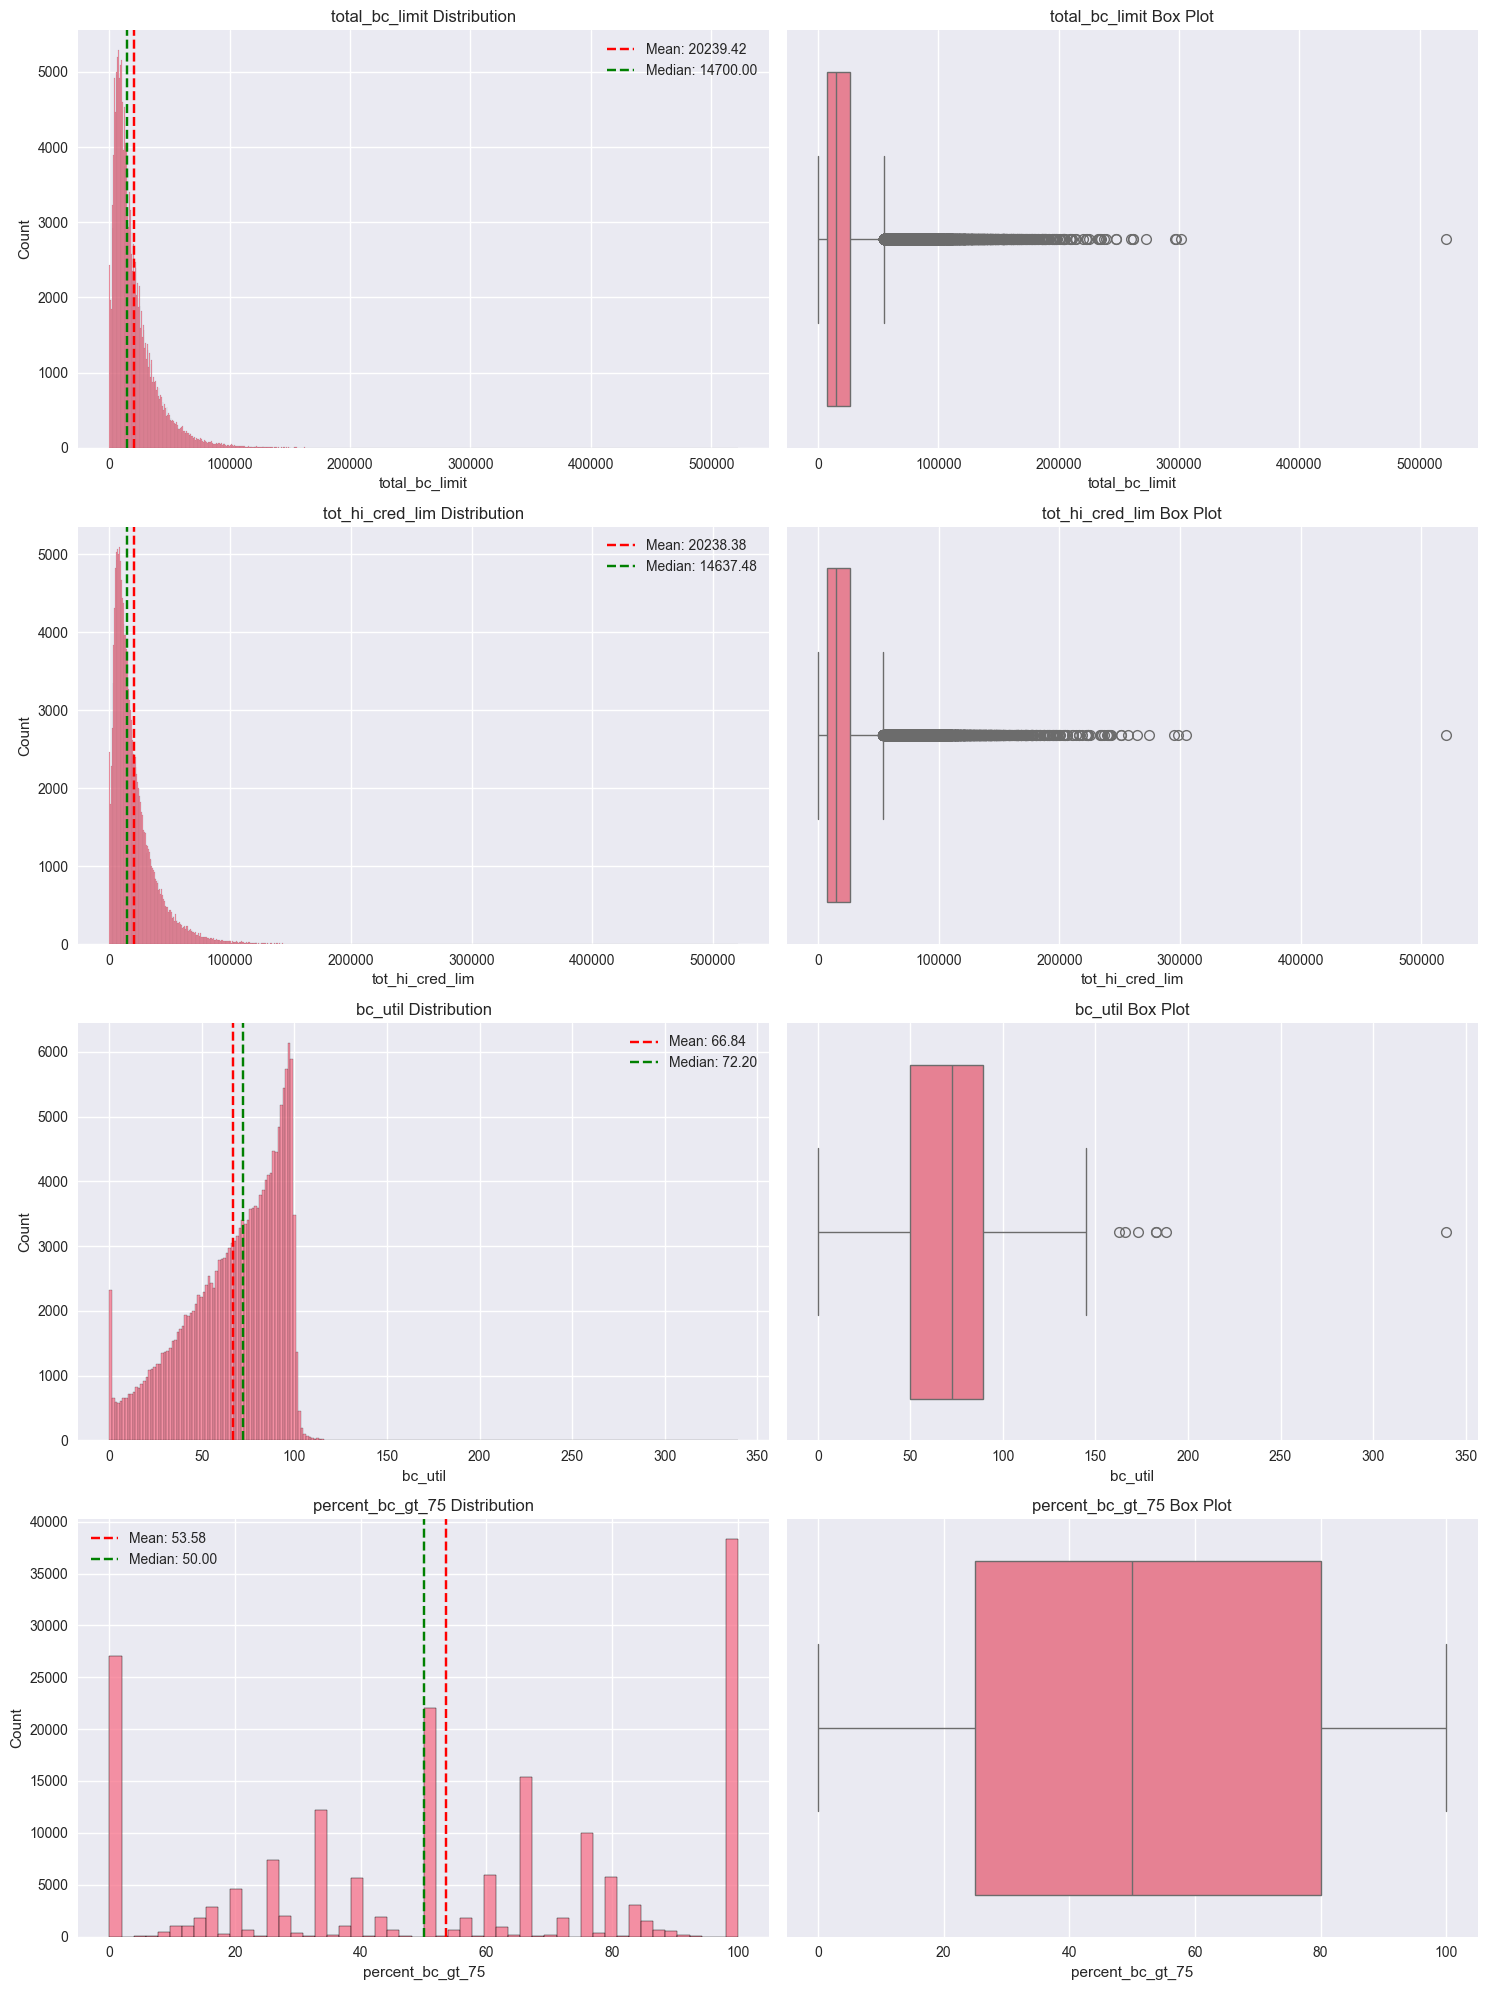


=== Summary Statistics ===

total_bc_limit:
Mean: 20239.42
Median: 14700.00
Skewness: 2.62
% difference (mean vs median): 37.68%
Percentage of values above mean: 35.94%

tot_hi_cred_lim:
Mean: 20238.38
Median: 14637.48
Skewness: 2.64
% difference (mean vs median): 38.26%
Percentage of values above mean: 35.89%

bc_util:
Mean: 66.84
Median: 72.20
Skewness: -0.69
% difference (mean vs median): -7.42%
Percentage of values above mean: 56.27%

percent_bc_gt_75:
Mean: 53.58
Median: 50.00
Skewness: -0.12
% difference (mean vs median): 7.15%
Percentage of values above mean: 47.94%


In [89]:
# Create plotting function
def analyze_distribution(df, features):
    fig, axes = plt.subplots(len(features), 2, figsize=(15, 5*len(features)))
    
    for idx, feature in enumerate(features):
        # Regular histogram
        sns.histplot(data=df, x=feature, ax=axes[idx, 0])
        axes[idx, 0].axvline(df[feature].mean(), color='r', linestyle='--', label=f'Mean: {df[feature].mean():.2f}')
        axes[idx, 0].axvline(df[feature].median(), color='g', linestyle='--', label=f'Median: {df[feature].median():.2f}')
        axes[idx, 0].set_title(f'{feature} Distribution')
        axes[idx, 0].legend()
        
        # Box plot to show outliers
        sns.boxplot(data=df, x=feature, ax=axes[idx, 1])
        axes[idx, 1].set_title(f'{feature} Box Plot')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n=== Summary Statistics ===")
    for feature in features:
        print(f"\n{feature}:")
        print(f"Mean: {df[feature].mean():.2f}")
        print(f"Median: {df[feature].median():.2f}")
        print(f"Skewness: {df[feature].skew():.2f}")
        print(f"% difference (mean vs median): {((df[feature].mean() - df[feature].median())/df[feature].median()*100):.2f}%")
        
        # Calculate what percentage of values are above mean
        pct_above_mean = (df[feature] > df[feature].mean()).mean() * 100
        print(f"Percentage of values above mean: {pct_above_mean:.2f}%")

# Analyze distributions for credit features
credit_features = ['total_bc_limit', 'tot_hi_cred_lim', 'bc_util', 'percent_bc_gt_75']
analyze_distribution(df[df['no_credit_card_history'] != 1], credit_features)

Looking at these statistics, we can make some important observations:

1. Credit Limit Features (total_bc_limit and tot_hi_cred_lim):
- High positive skewness (~2.6)
- Mean is about 38% higher than median
- Only about 36% of values are above mean
- Clear case for using median imputation due to right-skewed distribution
- Using mean would overestimate typical credit limits

2. Utilization Features (bc_util and percent_bc_gt_75):
- Much more symmetrical distribution (skewness near 0)
- Mean and median are fairly close (7-8% difference)
- Nearly 50% of values above mean
- Could reasonably use either mean or median
- Slight negative skew in bc_util suggests mean might be more representative

This hybrid approach uses median for highly skewed credit limit features, uses mean for more normally distributed utilization features, and maintains zero imputation for no credit history cases

In [90]:
del df

In [91]:
def impute_credit_features(df):
    """
    Impute credit-related features using a hybrid approach:
    - Median for skewed credit limit features
    - Mean for more normally distributed utilization features
    """
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df = df.copy()
    
    # First create flag for no credit card history
    df['no_credit_card_history'] = (
        df['total_bc_limit'].isnull() & 
        df['tot_hi_cred_lim'].isnull() & 
        df['bc_util'].isnull() & 
        df['percent_bc_gt_75'].isnull()
    ).astype(int)
    
    # Impute credit limit features using median (due to high skewness)
    for col in ['total_bc_limit', 'tot_hi_cred_lim']:
        # Calculate median for cases where we have credit history
        median_val = df[df[col].notnull()][col].median()
        
        # Where no_credit_card_history is 1, fill with 0
        # For other missing values, fill with median
        df[col] = df[col].fillna(df.apply(
            lambda x: 0 if x['no_credit_card_history'] == 1 else median_val, 
            axis=1
        ))
    
    # Impute utilization features using mean (more normally distributed)
    for col in ['bc_util', 'percent_bc_gt_75']:
        # Calculate mean for non-zero credit limit cases
        mean_val = df[
            (df[col].notnull()) & 
            (df['total_bc_limit'] > 0)
        ][col].mean()
        
        # Where no_credit_card_history is 1, fill with 0
        # For other missing values, fill with mean of non-zero credit limit cases
        df[col] = df[col].fillna(df.apply(
            lambda x: 0 if x['no_credit_card_history'] == 1 else mean_val,
            axis=1
        ))
    
    return df


# Store original statistics
print("=== Before Imputation ===")
print("\nMissing value counts:")
for col in ['total_bc_limit', 'tot_hi_cred_lim', 'bc_util', 'percent_bc_gt_75']:
    print(f"{col}: {data[col].isnull().sum()}")
    if data[col].notnull().any():
        print(f"Existing values - Mean: {data[col].mean():.2f}, Median: {data[col].median():.2f}")

# Apply imputation
data = impute_credit_features(data)

# Verify results
print("\n=== After Imputation ===")
print("\nMissing value counts:")
for col in ['total_bc_limit', 'tot_hi_cred_lim', 'bc_util', 'percent_bc_gt_75']:
    print(f"{col}: {data[col].isnull().sum()}")
    if data[col].notnull().any():
        print(f"Existing values - Mean: {data[col].mean():.2f}, Median: {data[col].median():.2f}")

# Check distribution of values for no credit history vs others
print("\nValue distribution by credit history status:")
no_history_mask = data['no_credit_card_history'] == 1
for col in ['total_bc_limit', 'tot_hi_cred_lim', 'bc_util', 'percent_bc_gt_75']:
    print(f"\n{col}:")
    print(f"No history - mean: {data[no_history_mask][col].mean():.2f}")
    print(f"Has history - mean: {data[~no_history_mask][col].mean():.2f}")
    print(f"Has history - median: {data[~no_history_mask][col].median():.2f}")

=== Before Imputation ===

Missing value counts:
total_bc_limit: 7495
Existing values - Mean: 20239.42, Median: 14700.00
tot_hi_cred_lim: 7495
Existing values - Mean: 20238.38, Median: 14637.48
bc_util: 9124
Existing values - Mean: 66.84, Median: 72.20
percent_bc_gt_75: 9038
Existing values - Mean: 53.58, Median: 50.00

=== After Imputation ===

Missing value counts:
total_bc_limit: 0
Existing values - Mean: 19438.74, Median: 14000.00
tot_hi_cred_lim: 0
Existing values - Mean: 19437.75, Median: 13977.78
bc_util: 0
Existing values - Mean: 64.20, Median: 70.30
percent_bc_gt_75: 0
Existing values - Mean: 51.46, Median: 50.00

Value distribution by credit history status:

total_bc_limit:
No history - mean: 0.00
Has history - mean: 20239.42
Has history - median: 14700.00

tot_hi_cred_lim:
No history - mean: 0.00
Has history - mean: 20238.38
Has history - median: 14637.48

bc_util:
No history - mean: 0.00
Has history - mean: 66.84
Has history - median: 71.80

percent_bc_gt_75:
No history - m

In [92]:
print("\n=== Missing Value Analysis After Cleaning ===")
missing_stats = pd.DataFrame({
    'Missing Count': data.isnull().sum(),
    'Missing Percentage': (data.isnull().sum() / len(data) * 100).round(2)
}).sort_values('Missing Percentage', ascending=False)
print(missing_stats)


=== Missing Value Analysis After Cleaning ===
                             Missing Count  Missing Percentage
mths_since_last_major_derog         156708               82.71
desc                                107453               56.72
mths_since_recent_inq                27985               14.77
tot_cur_bal                          27741               14.64
emp_length                            7926                4.18
revol_util                             127                0.07
loan_amnt                                0                0.00
bad_flag                                 0                0.00
internal_score                           0                0.00
tot_hi_cred_lim                          0                0.00
total_bc_limit                           0                0.00
dti                                      0                0.00
inq_last_6mths                           0                0.00
term                                     0                0.00
bc_util 

**Observations**:
1. mths_since_last_major_derog (82.71% missing):
- This high missing percentage likely indicates no derogatory marks
- Missing values here could be a positive signal for credit quality
- We should probably create a flag for "no_derog_history" before imputation
- **Impute Strategy**: We could set missing values to 120(10 years) which would be a high number to indicate there was no derogatory but that could significantly skew the distribution and affect scaling/normalization, especially since it is 82.71% of the data. So, imputing with **-1** would be a better strategy as it will clearly differentiate between missing values (no derogatory marks) and actual values. Also, the neural network can easily learn that -1 is a special value and will work well with ReLU activation.

2. desc (56.72% missing):
- This is a text description field so high missing rate is common for optional text fields
Given the high missing rate and being a text field, we might want to drop it as we're not doing any text analysis

3. mths_since_recent_inq (14.77% missing):
- Could be related to inq_last_6mths
- Missing might indicate no recent inquiries
- Should analyze relationship with inq_last_6mths before imputation

In [93]:
def handle_derog_feature(df):
    """
    Handle mths_since_last_major_derog using -1 imputation for no derogatory history
    """
    df = df.copy()
    
    # Create flag for no derogatory history
    df['no_derog_history'] = df['mths_since_last_major_derog'].isnull().astype(int)
    
    # Impute missing values with -1 (indicating no derogatory marks)
    df['mths_since_last_major_derog'] = df['mths_since_last_major_derog'].fillna(-1)
    
    return df

# Store original statistics
print("=== Before Processing ===")
print("\nMissing values:", data['mths_since_last_major_derog'].isnull().sum())
print("\nNon-missing statistics:")
print(data['mths_since_last_major_derog'].dropna().describe())

# Process feature
data = handle_derog_feature(data)

# Verify results
print("\n=== After Processing ===")
print("\nMissing values:", data['mths_since_last_major_derog'].isnull().sum())

print("\nValue distribution:")
print(data['mths_since_last_major_derog'].value_counts().head())

print("\nDefault rate by derog history:")
print(data.groupby('no_derog_history')['bad_flag'].mean())

print("\nStatistics excluding -1 values:")
print(data[data['mths_since_last_major_derog'] != -1]['mths_since_last_major_derog'].describe())

=== Before Processing ===

Missing values: 156708

Non-missing statistics:
count    32749.000000
mean        41.780054
std         20.984599
min          0.000000
25%         25.000000
50%         41.000000
75%         58.000000
max        165.000000
Name: mths_since_last_major_derog, dtype: float64

=== After Processing ===

Missing values: 0

Value distribution:
mths_since_last_major_derog
-1.0     156708
 38.0       573
 40.0       565
 41.0       564
 42.0       563
Name: count, dtype: int64

Default rate by derog history:
no_derog_history
0    0.059574
1    0.071324
Name: bad_flag, dtype: float64

Statistics excluding -1 values:
count    32749.000000
mean        41.780054
std         20.984599
min          0.000000
25%         25.000000
50%         41.000000
75%         58.000000
max        165.000000
Name: mths_since_last_major_derog, dtype: float64


=== Initial Analysis ===

Missing values: 27985

Distribution of non-missing values:
count    161472.000000
mean          6.993634
std           5.879707
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          24.000000
Name: mths_since_recent_inq, dtype: float64

=== Relationship with Recent Inquiries ===

Missing rate by number of inquiries:
                mths_since_recent_inq
inq_last_6mths                       
0.0                             0.250
1.0                             0.042
2.0                             0.041
3.0                             0.044
4.0                             0.014
5.0                             0.030
6.0                             0.023
7.0                             0.231
8.0                             0.143

Default rate when mths_since_recent_inq is missing:
0.07353939610505628

Default rate when mths_since_recent_inq is present:
0.06855677764565993


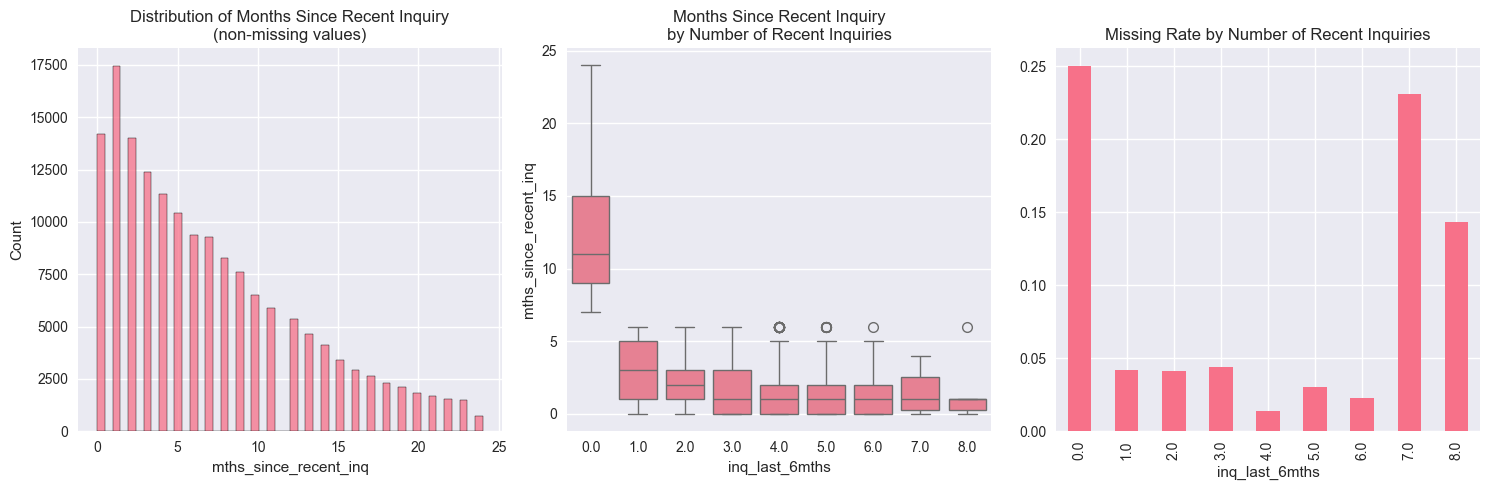

In [94]:
# Initial analysis
print("=== Initial Analysis ===")
print("\nMissing values:", data['mths_since_recent_inq'].isnull().sum())
print("\nDistribution of non-missing values:")
print(data['mths_since_recent_inq'].dropna().describe())

# Analyze relationship with inq_last_6mths
print("\n=== Relationship with Recent Inquiries ===")
print("\nMissing rate by number of inquiries:")
missing_by_inq = data.groupby('inq_last_6mths').agg({
    'mths_since_recent_inq': lambda x: x.isnull().mean()
}).round(3)
print(missing_by_inq)

# Default rates
print("\nDefault rate when mths_since_recent_inq is missing:")
print(data[data['mths_since_recent_inq'].isnull()]['bad_flag'].mean())
print("\nDefault rate when mths_since_recent_inq is present:")
print(data[data['mths_since_recent_inq'].notnull()]['bad_flag'].mean())

# Plot relationships
plt.figure(figsize=(15, 5))

# Distribution of non-missing values
plt.subplot(1, 3, 1)
sns.histplot(data=data['mths_since_recent_inq'].dropna(), bins=50)
plt.title('Distribution of Months Since Recent Inquiry\n(non-missing values)')

# Box plot by number of inquiries
plt.subplot(1, 3, 2)
sns.boxplot(data=data[data['mths_since_recent_inq'].notnull()], 
            x='inq_last_6mths', y='mths_since_recent_inq')
plt.title('Months Since Recent Inquiry\nby Number of Recent Inquiries')

# Missing rate by number of inquiries
plt.subplot(1, 3, 3)
missing_by_inq['mths_since_recent_inq'].plot(kind='bar')
plt.title('Missing Rate by Number of Recent Inquiries')
plt.tight_layout()
plt.show()



Based on this, our impute strategy could be:
1. When inq_last_6mths = 0:
    - Use -1 to indicate no inquiry history
    - This accounts for the largest group of missing values
2. For other missing values (inq_last_6mths > 0):
    - Use the median value based on the number of inquiries
    - This preserves the relationship shown in the box plot

**Note**: inq_last_6mths=0 could also mean there were inquiries more than 6 months before. Before deciding, let's check the value_counts including missing values for mths_since_recent_inq when inq_last_6mths=0 just to be sure of our impute strategy

In [95]:
# Filter for cases where inq_last_6mths = 0
zero_inq_cases = data[data['inq_last_6mths'] == 0]

print("=== Analysis of cases where inq_last_6mths = 0 ===")
print("\nTotal cases with zero inquiries:", len(zero_inq_cases))

print("\nValue distribution of mths_since_recent_inq:")
print(zero_inq_cases['mths_since_recent_inq'].value_counts(dropna=False).sort_index())

print("\nSummary statistics for non-missing values:")
print(zero_inq_cases['mths_since_recent_inq'].describe())

# Look at default rates
print("\nDefault rates:")
print("\nWhen mths_since_recent_inq is missing:")
print(zero_inq_cases[zero_inq_cases['mths_since_recent_inq'].isnull()]['bad_flag'].mean())
print("\nWhen mths_since_recent_inq is present:")
print(zero_inq_cases[zero_inq_cases['mths_since_recent_inq'].notnull()]['bad_flag'].mean())

# Distribution for different ranges of mths_since_recent_inq
print("\nDistribution of values by range:")
bins = [0, 6, 12, 18, 24, float('inf')]
labels = ['0-6 months', '7-12 months', '13-18 months', '19-24 months', '24+ months']
non_null_cases = zero_inq_cases[zero_inq_cases['mths_since_recent_inq'].notnull()]
print(pd.cut(non_null_cases['mths_since_recent_inq'], bins=bins, labels=labels).value_counts())

=== Analysis of cases where inq_last_6mths = 0 ===

Total cases with zero inquiries: 96518

Value distribution of mths_since_recent_inq:
mths_since_recent_inq
7.0      9289
8.0      8298
9.0      7617
10.0     6527
11.0     5901
12.0     5380
13.0     4641
14.0     4135
15.0     3401
16.0     2914
17.0     2616
18.0     2316
19.0     2102
20.0     1842
21.0     1684
22.0     1520
23.0     1468
24.0      709
NaN     24158
Name: count, dtype: int64

Summary statistics for non-missing values:
count    72360.000000
mean        12.342247
std          4.542813
min          7.000000
25%          9.000000
50%         11.000000
75%         15.000000
max         24.000000
Name: mths_since_recent_inq, dtype: float64

Default rates:

When mths_since_recent_inq is missing:
0.059897342495239675

When mths_since_recent_inq is present:
0.0546849087893864

Distribution of values by range:
mths_since_recent_inq
7-12 months     43012
13-18 months    20023
19-24 months     9325
0-6 months          0
24+ m

Looking at the data:
1. For cases where inq_last_6mths = 0:
    - All non-missing values are ≥ 7 months (makes perfect sense as these are cases with no inquiries in last 6 months)
    - Range is 7-24 months
    - Mean is ~12.3 months
    - Most common values are 7-12 months (43,012 cases)
    - No values in 0-6 months (which is correct)

2. Missing Pattern:
    - 24,158 missing values out of 96,518 cases
    - Similar default rates between missing (6.0%) and non-missing (5.5%)

This means our previous assumption was wrong. Missing values when inq_last_6mths = 0 don't necessarily indicate no inquiry history - they might just be older inquiries that are no longer tracked in the system.

**Revised Imputation Strategy**:
- For cases where inq_last_6mths = 0 and mths_since_recent_inq is missing: Should impute with median of non-missing values for zero inquiry cases (~11 months)
- Should NOT use -1 as we initially thought
- Use median based on the number of inquiries for other missing cases (where inq_last_6mths > 0)

In [96]:
def handle_inquiry_feature(df):
    """
    Handle mths_since_recent_inq imputation based on inq_last_6mths patterns
    """
    df = df.copy()
    
    # For cases where inq_last_6mths = 0
    zero_inq_median = df[
        (df['inq_last_6mths'] == 0) & 
        (df['mths_since_recent_inq'].notnull())
    ]['mths_since_recent_inq'].median()
    
    # For other cases, calculate median by number of inquiries
    medians_by_inq = df[
        (df['inq_last_6mths'] > 0) & 
        (df['mths_since_recent_inq'].notnull())
    ].groupby('inq_last_6mths')['mths_since_recent_inq'].median()
    
    # Impute missing values
    df['mths_since_recent_inq'] = df.apply(
        lambda x: zero_inq_median if (pd.isnull(x['mths_since_recent_inq']) and x['inq_last_6mths'] == 0)
        else medians_by_inq[x['inq_last_6mths']] if pd.isnull(x['mths_since_recent_inq'])
        else x['mths_since_recent_inq'],
        axis=1
    )
    
    return df

In [97]:
# Store original statistics
print("=== Before Processing ===")
print("\nMissing values:", data['mths_since_recent_inq'].isnull().sum())

print("\nStatistics for cases with zero inquiries:")
zero_inq_stats = data[data['inq_last_6mths'] == 0]['mths_since_recent_inq'].describe()
print(zero_inq_stats)

print("\nStatistics by number of inquiries:")
print(data.groupby('inq_last_6mths')['mths_since_recent_inq'].describe())

# Apply imputation
data = handle_inquiry_feature(data)

# Verify results
print("\n=== After Processing ===")
print("\nMissing values:", data['mths_since_recent_inq'].isnull().sum())

print("\nUpdated statistics for cases with zero inquiries:")
zero_inq_stats_after = data[data['inq_last_6mths'] == 0]['mths_since_recent_inq'].describe()
print(zero_inq_stats_after)

print("\nUpdated statistics by number of inquiries:")
print(data.groupby('inq_last_6mths')['mths_since_recent_inq'].describe())

# Distribution validation
print("\nValue distribution after imputation:")
print(data['mths_since_recent_inq'].value_counts().sort_index().head())

# Verify logical consistency
print("\nVerify no values < 7 months when inq_last_6mths = 0:")
invalid_cases = data[
    (data['inq_last_6mths'] == 0) & 
    (data['mths_since_recent_inq'] < 7)
].shape[0]
print("Number of invalid cases:", invalid_cases)

=== Before Processing ===

Missing values: 27985

Statistics for cases with zero inquiries:
count    72360.000000
mean        12.342247
std          4.542813
min          7.000000
25%          9.000000
50%         11.000000
75%         15.000000
max         24.000000
Name: mths_since_recent_inq, dtype: float64

Statistics by number of inquiries:
                  count       mean       std  min   25%   50%   75%   max
inq_last_6mths                                                           
0.0             72360.0  12.342247  4.542813  7.0  9.00  11.0  15.0  24.0
1.0             51203.0   3.131281  1.973228  0.0  1.00   3.0   5.0   6.0
2.0             23700.0   2.209451  1.754480  0.0  1.00   2.0   3.0   6.0
3.0             10777.0   1.754292  1.611005  0.0  0.00   1.0   3.0   6.0
4.0              2326.0   1.374893  1.429203  0.0  0.00   1.0   2.0   6.0
5.0               749.0   1.268358  1.327949  0.0  0.00   1.0   2.0   6.0
6.0               341.0   1.228739  1.267418  0.0  0.00   1.

**Observations**:
The imputation appears to have successfully:
- Preserved the original distributions
- Maintained business logic
- Kept the relationships between variables intact

In [98]:
# For the description feature we can simply drop the column as we don't plan on doing any text analysis especially with high amount of missing values (107, 453)
data = data.drop('desc', axis=1)

In [99]:
print("\n=== Missing Value Analysis After Cleaning ===")
missing_stats = pd.DataFrame({
    'Missing Count': data.isnull().sum(),
    'Missing Percentage': (data.isnull().sum() / len(data) * 100).round(2)
}).sort_values('Missing Percentage', ascending=False)
print(missing_stats)


=== Missing Value Analysis After Cleaning ===
                             Missing Count  Missing Percentage
tot_cur_bal                          27741               14.64
emp_length                            7926                4.18
revol_util                             127                0.07
loan_amnt                                0                0.00
mths_since_recent_inq                    0                0.00
no_credit_card_history                   0                0.00
bad_flag                                 0                0.00
internal_score                           0                0.00
tot_hi_cred_lim                          0                0.00
mths_since_last_major_derog              0                0.00
total_bc_limit                           0                0.00
inq_last_6mths                           0                0.00
term                                     0                0.00
dti                                      0                0.00
bc_util 

- For tot_cur_bal, lets analyze its distribution, relationship with other credit-related features and see if missing values have any pattern with loan purpose or other features

=== Total Current Balance Analysis ===

Missing values: 27741
Missing percentage: 14.64%

=== Relationship with Credit Card History ===

Missing tot_cur_bal by credit card history:
tot_cur_bal             False  True 
no_credit_card_history              
0                       0.889  0.111
1                       0.000  1.000

=== Distribution Statistics (non-missing) ===
count    1.617160e+05
mean     1.373215e+05
std      1.507358e+05
min      0.000000e+00
25%      2.746575e+04
50%      8.076050e+04
75%      2.082122e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

=== Correlation with Credit Features ===
tot_cur_bal        1.000000
total_bc_limit     0.302388
tot_hi_cred_lim    0.300950
revol_util         0.042380
bc_util            0.002220
Name: tot_cur_bal, dtype: float64

=== Missing Pattern by Loan Purpose ===
purpose
wedding               0.346696
small_business        0.339014
renewable_energy      0.303279
car                   0.296636
house                 0.2

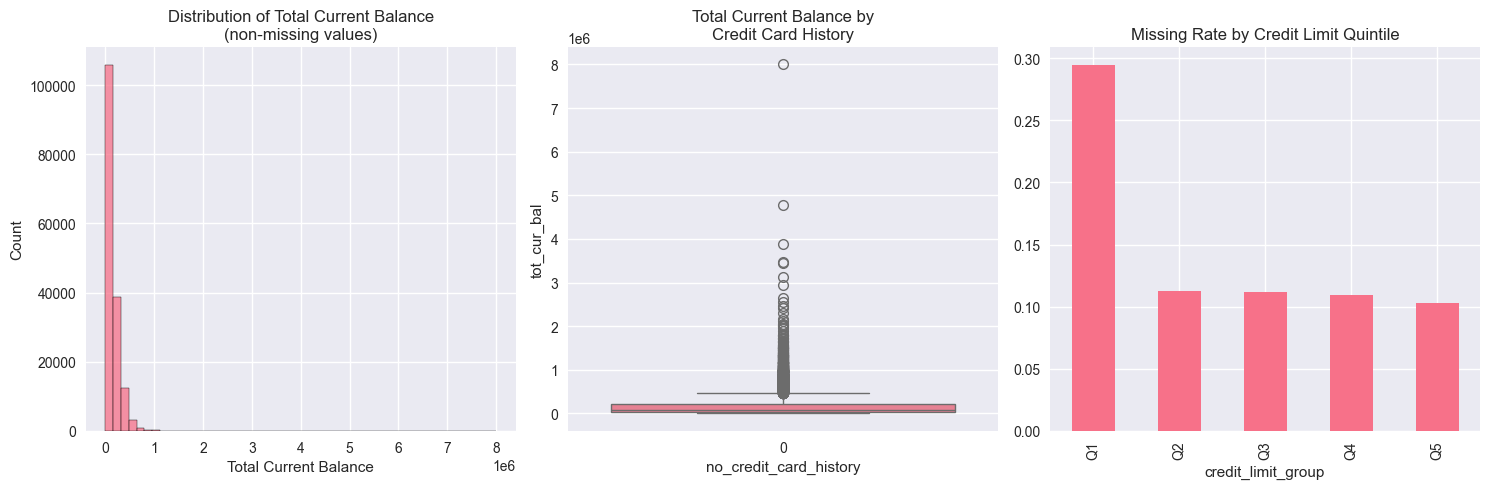


=== Summary Statistics by Credit Card History ===
                           count           mean           std  min       25%  \
no_credit_card_history                                                         
0                       161716.0  137321.452039  150735.82168  0.0  27465.75   
1                            0.0            NaN           NaN  NaN       NaN   

                            50%        75%        max  
no_credit_card_history                                 
0                       80760.5  208212.25  8000078.0  
1                           NaN        NaN        NaN  


In [100]:
print("=== Total Current Balance Analysis ===")
print("\nMissing values:", data['tot_cur_bal'].isnull().sum())
print("Missing percentage: {:.2f}%".format(data['tot_cur_bal'].isnull().mean() * 100))

# Relationship with no_credit_card_history
print("\n=== Relationship with Credit Card History ===")
print("\nMissing tot_cur_bal by credit card history:")
missing_by_history = pd.crosstab(
    data['no_credit_card_history'],
    data['tot_cur_bal'].isnull(),
    normalize='index'
).round(3)
print(missing_by_history)

# Distribution of non-missing values
print("\n=== Distribution Statistics (non-missing) ===")
print(data['tot_cur_bal'].describe())

# Relationship with other credit metrics
credit_features = ['tot_cur_bal', 'tot_hi_cred_lim', 'total_bc_limit', 'bc_util', 'revol_util']
print("\n=== Correlation with Credit Features ===")
corr = data[credit_features].corr()['tot_cur_bal'].sort_values(ascending=False)
print(corr)

# Missing pattern by purpose
print("\n=== Missing Pattern by Loan Purpose ===")
missing_by_purpose = data.groupby('purpose')['tot_cur_bal'].apply(
    lambda x: x.isnull().mean()
).sort_values(ascending=False)
print(missing_by_purpose)

# Default rates
print("\n=== Default Rates ===")
print("When tot_cur_bal is missing:", 
      data[data['tot_cur_bal'].isnull()]['bad_flag'].mean())
print("When tot_cur_bal is present:", 
      data[data['tot_cur_bal'].notnull()]['bad_flag'].mean())

# Visualizations
plt.figure(figsize=(15, 5))

# Distribution plot
plt.subplot(1, 3, 1)
sns.histplot(data=data[data['tot_cur_bal'].notnull()], 
             x='tot_cur_bal', bins=50)
plt.title('Distribution of Total Current Balance\n(non-missing values)')
plt.xlabel('Total Current Balance')

# Box plot by credit history
plt.subplot(1, 3, 2)
sns.boxplot(data=data[data['tot_cur_bal'].notnull()], 
            x='no_credit_card_history', 
            y='tot_cur_bal')
plt.title('Total Current Balance by\nCredit Card History')

# Missing rate by credit limit groups
plt.subplot(1, 3, 3)
data['credit_limit_group'] = pd.qcut(data['tot_hi_cred_lim'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
missing_by_limit = data.groupby('credit_limit_group')['tot_cur_bal'].apply(
    lambda x: x.isnull().mean()
)
missing_by_limit.plot(kind='bar')
plt.title('Missing Rate by Credit Limit Quintile')
plt.tight_layout()
plt.show()

# Additional insights for imputation strategy
print("\n=== Summary Statistics by Credit Card History ===")
print(data.groupby('no_credit_card_history')['tot_cur_bal'].describe())

**This analysis reveals several important insights**:
1. Strong Relationship with Credit Card History:
- 100% missing for those with no credit card history (no_credit_card_history = 1)
- Only 11.1% missing for those with credit history (no_credit_card_history = 0)
- This indicates a clear pattern: no credit card history → no current balance

2. Risk Pattern:
- Much higher default rate when tot_cur_bal is missing (13.49%)
- Lower default rate when tot_cur_bal is present (5.80%)
- This suggests missing values might indicate higher risk

3. Distribution and Correlations:
- Right-skewed distribution
- Weak to moderate correlations with credit limits (around 0.3)
- Very weak correlations with utilization metrics

4. Missing Pattern by Purpose:
- Higher missing rates for wedding (34.7%), small_business (33.9%)
- Lower missing rates for credit_card (11.9%), debt_consolidation (13.6%)
- Makes sense as some purposes might not require prior credit

**Imputation Strategy**:
1. For no_credit_card_history = 1:
- Impute with 0 (they have no credit cards, so no current balance)
2. For no_credit_card_history = 0:
- Use median grouped by purpose (since missing rates vary significantly by purpose)
- (Could also consider credit limit in the imputation)

In [101]:
def impute_current_balance(df):
    """
    Impute tot_cur_bal based on credit history and purpose
    
    Args:
        df (pd.DataFrame): Input dataframe with tot_cur_bal, no_credit_card_history, and purpose columns
        
    Returns:
        pd.DataFrame: Dataframe with imputed tot_cur_bal values
    """
    df = df.copy()
    
    # First, impute 0 for no credit history
    df.loc[df['no_credit_card_history'] == 1, 'tot_cur_bal'] = 0
    
    # Calculate medians by purpose using only cases with credit history
    medians_by_purpose = df[
        (df['no_credit_card_history'] == 0) & 
        (df['tot_cur_bal'].notnull())
    ].groupby('purpose')['tot_cur_bal'].median()
    
    # Impute remaining missing values using purpose medians
    for purpose in df['purpose'].unique():
        mask = (
            (df['tot_cur_bal'].isnull()) & 
            (df['purpose'] == purpose) & 
            (df['no_credit_card_history'] == 0)
        )
        df.loc[mask, 'tot_cur_bal'] = medians_by_purpose[purpose]
    
    return df


In [102]:
# Testing and verification
# Before imputation analysis
print("=== Before Imputation ===")
print(f"Missing values: {data['tot_cur_bal'].isnull().sum()}")

print("\nMissing by credit history:")
print(pd.crosstab(
      data['no_credit_card_history'],
      data['tot_cur_bal'].isnull(),
      normalize='index'
))

print("\nOriginal distribution (non-missing):")
print(data['tot_cur_bal'].describe())

# Apply imputation
data = impute_current_balance(data)

# After imputation analysis
print("\n=== After Imputation ===")
print(f"Missing values: {data['tot_cur_bal'].isnull().sum()}")

print("\nDistribution by credit history:")
print(data.groupby('no_credit_card_history')['tot_cur_bal'].describe())

print("\nDistribution by purpose:")
purpose_stats = data.groupby('purpose')['tot_cur_bal'].describe()
print(purpose_stats[['count', 'mean', '50%']])

# Verification checks
print("\n=== Verification Checks ===")
print("Check for zero values where no credit history:")
non_zero_no_history = (data[data['no_credit_card_history'] == 1]['tot_cur_bal'] != 0).sum()
print(f"Number of non-zero values for no credit history: {non_zero_no_history}")

print("\nCheck purpose-based imputation:")
for purpose in data['purpose'].unique():
      purpose_median = data[
      (data['no_credit_card_history'] == 0) & 
      (data['tot_cur_bal'].notnull())
      ].groupby('purpose')['tot_cur_bal'].median()[purpose]
      
      imputed_count = ((data['purpose'] == purpose) & 
                  (data['no_credit_card_history'] == 0) & 
                  (data['tot_cur_bal'] == purpose_median)).sum()
      
      if imputed_count > 0:
            print(f"{purpose}: {imputed_count} values imputed with median {purpose_median:.2f}")

=== Before Imputation ===
Missing values: 27741

Missing by credit history:
tot_cur_bal                False     True 
no_credit_card_history                    
0                       0.888735  0.111265
1                       0.000000  1.000000

Original distribution (non-missing):
count    1.617160e+05
mean     1.373215e+05
std      1.507358e+05
min      0.000000e+00
25%      2.746575e+04
50%      8.076050e+04
75%      2.082122e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

=== After Imputation ===
Missing values: 0

Distribution by credit history:
                           count           mean            std  min       25%  \
no_credit_card_history                                                          
0                       181962.0  130967.876818  143463.906668  0.0  30707.25   
1                         7495.0       0.000000       0.000000  0.0      0.00   

                            50%        75%        max  
no_credit_card_history                        

- Now, let's analyze emp_length distribution and relationships

=== Employment Length Analysis ===

Missing values: 7926
Missing percentage: 4.18%

Value distribution:
emp_length
0.0     13312
1.0     11504
2.0     16257
3.0     14058
4.0     10905
5.0     14361
6.0     11981
7.0     11287
8.0      9040
9.0      7178
10.0    61648
NaN      7926
Name: count, dtype: int64

=== Relationship with Annual Income ===
Mean income by employment length:
emp_length
0.0     68147.62
1.0     69458.42
2.0     70608.99
3.0     71092.74
4.0     69861.60
5.0     70046.86
6.0     70092.24
7.0     72222.11
8.0     72009.43
9.0     72851.77
10.0    78609.50
Name: annual_inc, dtype: float64

=== Default Rates ===
By employment length:
emp_length
0.0     0.0810
1.0     0.0708
2.0     0.0707
3.0     0.0691
4.0     0.0794
5.0     0.0719
6.0     0.0764
7.0     0.0702
8.0     0.0671
9.0     0.0695
10.0    0.0608
Name: bad_flag, dtype: float64

When emp_length is missing: 0.0829

=== Missing Pattern by Loan Purpose ===
purpose
renewable_energy      0.0656
other              

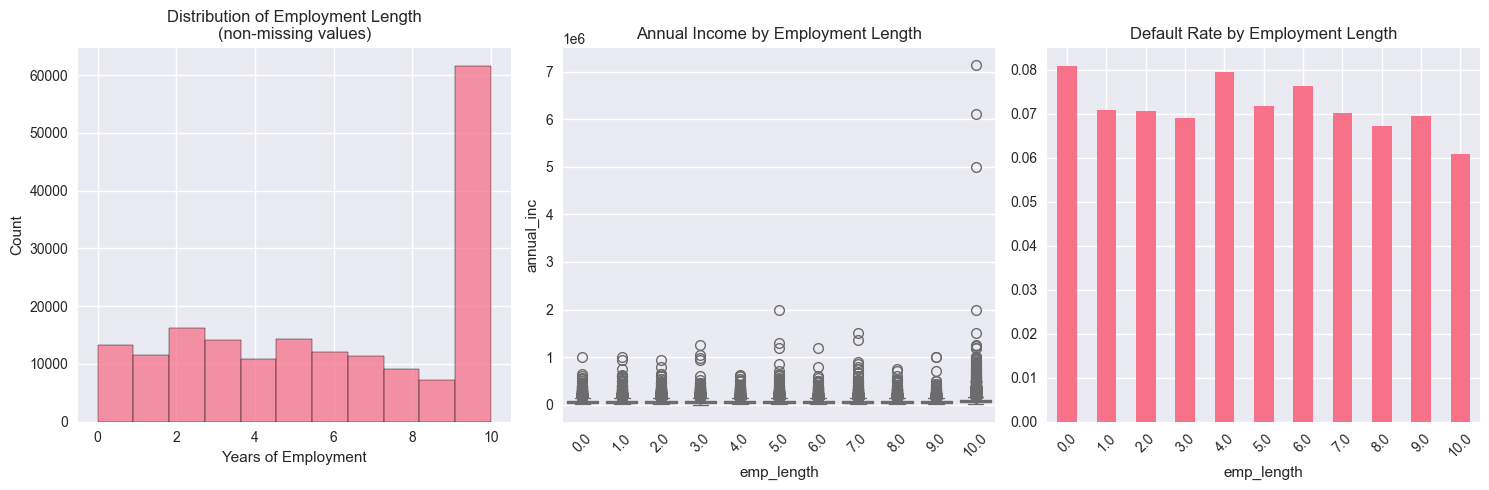


=== Missing Pattern by Home Ownership ===
home_ownership
OWN         0.0848
OTHER       0.0652
MORTGAGE    0.0389
RENT        0.0368
NONE        0.0238
Name: emp_length, dtype: float64

=== Employment Length Stats by Home Ownership ===
home_ownership
MORTGAGE    6.770632
NONE        7.000000
OTHER       6.488372
OWN         6.272032
RENT        5.188313
Name: emp_length, dtype: float64


In [103]:
# Initial analysis
print("=== Employment Length Analysis ===")
print("\nMissing values:", data['emp_length'].isnull().sum())
print("Missing percentage: {:.2f}%".format(data['emp_length'].isnull().mean() * 100))

# Value distribution
print("\nValue distribution:")
print(data['emp_length'].value_counts(dropna=False).sort_index())

# Analyze relationship with annual income
print("\n=== Relationship with Annual Income ===")
print("Mean income by employment length:")
print(data.groupby('emp_length')['annual_inc'].mean().round(2))

# Default rates
print("\n=== Default Rates ===")
print("By employment length:")
print(data.groupby('emp_length')['bad_flag'].mean().round(4))
print("\nWhen emp_length is missing:", data[data['emp_length'].isnull()]['bad_flag'].mean().round(4))

# Analyze missing pattern by purpose
print("\n=== Missing Pattern by Loan Purpose ===")
purpose_missing = data.groupby('purpose')['emp_length'].apply(
    lambda x: x.isnull().mean()
).sort_values(ascending=False)
print(purpose_missing.round(4))

# Relationship with loan amount
print("\n=== Relationship with Loan Amount ===")
print("Mean loan amount by employment length:")
print(data.groupby('emp_length')['loan_amnt'].mean().round(2))

# Visualizations
plt.figure(figsize=(15, 5))

# Distribution plot
plt.subplot(1, 3, 1)
sns.histplot(data=data[data['emp_length'].notnull()], x='emp_length', bins=11)
plt.title('Distribution of Employment Length\n(non-missing values)')
plt.xlabel('Years of Employment')

# Box plot of income by emp_length
plt.subplot(1, 3, 2)
sns.boxplot(data=data[data['emp_length'].notnull()], 
            x='emp_length', y='annual_inc')
plt.xticks(rotation=45)
plt.title('Annual Income by Employment Length')

# Default rate by emp_length
plt.subplot(1, 3, 3)
default_by_emp = data.groupby('emp_length')['bad_flag'].mean()
default_by_emp.plot(kind='bar')
plt.title('Default Rate by Employment Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional home ownership analysis
print("\n=== Missing Pattern by Home Ownership ===")
home_missing = data.groupby('home_ownership')['emp_length'].apply(
    lambda x: x.isnull().mean()
).sort_values(ascending=False)
print(home_missing.round(4))

# Employment length statistics by home ownership
print("\n=== Employment Length Stats by Home Ownership ===")
print(data.groupby('home_ownership')['emp_length'].mean())

**Patterns Observed**:
1. Employment Length Distribution:
- Strong right skew with peak at 10+ years (61,648 cases)
- Relatively even distribution between 0-9 years (7-16K cases each)
- Only 4.18% missing (7,926 cases)

2. Relationships:
- Income increases with employment length:
    - 0 years: ~68K
    - 10+ years: ~79K
    - Steady increase throughout

- Default rates show pattern:
    - Highest for 0 years (8.1%) and missing (8.3%)
    - Lowest for 10+ years (6.1%)
    - Generally decreasing with length

3. Missing Patterns:
- Home ownership related:
    - Higher missing rate in OWN (8.48%)
    - Lower in RENT (3.68%)
- Purpose related:
    - Higher in renewable_energy (6.56%)
    - Lower in wedding (1.41%)

**Strategy**:
- Use median imputation grouped by home_ownership
- Create a missing indicator flag since missing values show higher default rate

In [104]:
def impute_emp_length(df):
    """
    Impute employment length maintaining discrete values (0-10 years)
    using median values by home ownership
    """
    df = df.copy()
    
    # Create missing indicator
    df['emp_length_missing'] = df['emp_length'].isnull().astype(int)
    
    # Calculate medians by home ownership (will give discrete values)
    medians_by_ownership = df.groupby('home_ownership')['emp_length'].median()
    
    # Impute missing values
    for ownership in df['home_ownership'].unique():
        mask = (df['emp_length'].isnull()) & (df['home_ownership'] == ownership)
        df.loc[mask, 'emp_length'] = medians_by_ownership[ownership]
    
    return df

In [105]:
# Test the imputation
# Before imputation
print("=== Before Imputation ===")
print("\nValue counts:")
print(data['emp_length'].value_counts(dropna=False).sort_index())

print("\nMedians by home ownership:")
print(data.groupby('home_ownership')['emp_length'].median())

# Apply imputation
data = impute_emp_length(data)

# After imputation
print("\n=== After Imputation ===")
print("\nValue counts:")
print(data['emp_length'].value_counts().sort_index())

# Verify no decimal values
print("\nUnique values:")
print(sorted(data['emp_length'].unique()))

print("\nImputation count by home ownership:")
imputed = data[data['emp_length_missing'] == 1]
print(imputed.groupby('home_ownership').size())

=== Before Imputation ===

Value counts:
emp_length
0.0     13312
1.0     11504
2.0     16257
3.0     14058
4.0     10905
5.0     14361
6.0     11981
7.0     11287
8.0      9040
9.0      7178
10.0    61648
NaN      7926
Name: count, dtype: int64

Medians by home ownership:
home_ownership
MORTGAGE    8.0
NONE        9.0
OTHER       6.0
OWN         7.0
RENT        5.0
Name: emp_length, dtype: float64

=== After Imputation ===

Value counts:
emp_length
0.0     13312
1.0     11504
2.0     16257
3.0     14058
4.0     10905
5.0     17164
6.0     11984
7.0     12608
8.0     12838
9.0      7179
10.0    61648
Name: count, dtype: int64

Unique values:
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

Imputation count by home ownership:
home_ownership
MORTGAGE    3798
NONE           1
OTHER          3
OWN         1321
RENT        2803
dtype: int64


- Moving on to handling the revol_util feature. Given the very missing rate (0.07%), we might consider a simple median imputation or imputation based on bc_util if they are h9ghly corelated. We could also look at no_credit_card_history feature.

=== Revolving Utilization Analysis ===

Missing values: 127
Missing percentage: 0.07%

Distribution statistics:
count    189330.000000
mean         58.390322
std          23.007160
min           0.000000
25%          42.500000
50%          60.500000
75%          76.600000
max         140.400000
Name: revol_util, dtype: float64

=== Correlation with Credit Features ===
revol_util         1.000000
bc_util            0.730411
tot_hi_cred_lim   -0.192901
total_bc_limit    -0.193450
Name: revol_util, dtype: float64

=== Default Rates ===
When revol_util is missing: 0.11023622047244094
When revol_util is present: 0.06926530396661913

=== Missing Pattern by Credit Card History ===
Missing rate when no_credit_card_history = 1: 0.0016010673782521682
Missing rate when no_credit_card_history = 0: 0.0006320000879304471


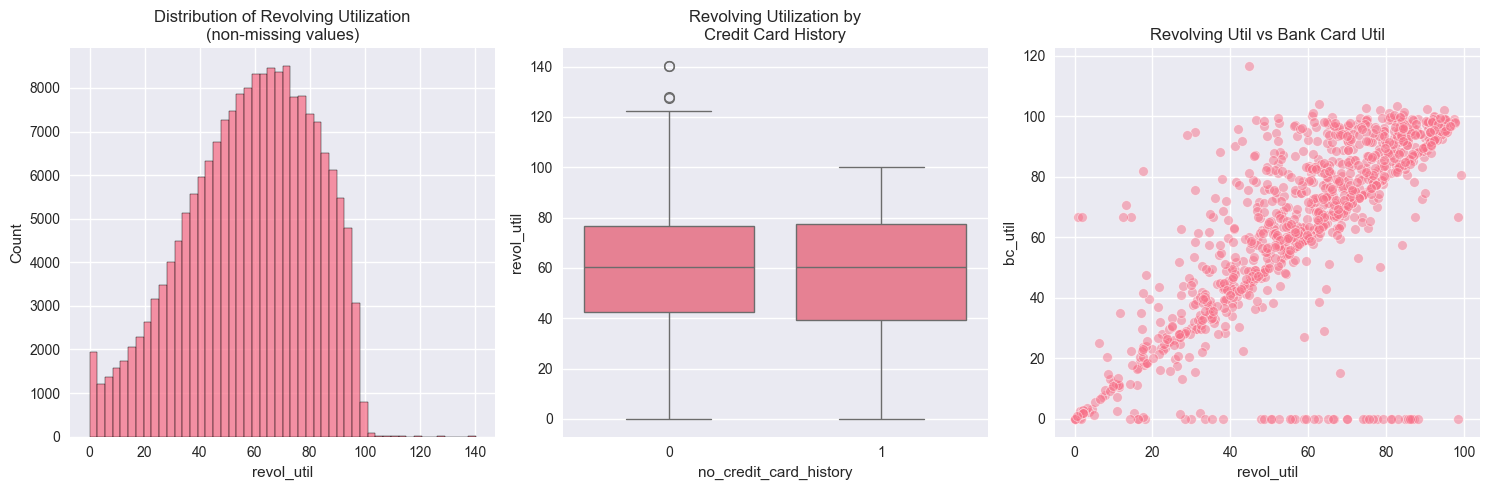

In [106]:
# Initial analysis
print("=== Revolving Utilization Analysis ===")
print("\nMissing values:", data['revol_util'].isnull().sum())
print("Missing percentage: {:.2f}%".format(data['revol_util'].isnull().mean() * 100))

# Distribution of non-missing values
print("\nDistribution statistics:")
print(data['revol_util'].describe())

# Relationship with other credit metrics
credit_features = ['revol_util', 'bc_util', 'total_bc_limit', 'tot_hi_cred_lim']
print("\n=== Correlation with Credit Features ===")
credit_corr = data[credit_features].corr()['revol_util'].sort_values(ascending=False)
print(credit_corr)

# Default rates
print("\n=== Default Rates ===")
print("When revol_util is missing:", 
      data[data['revol_util'].isnull()]['bad_flag'].mean())
print("When revol_util is present:", 
      data[data['revol_util'].notnull()]['bad_flag'].mean())

# Looking at missing patterns with credit card history
print("\n=== Missing Pattern by Credit Card History ===")
print("Missing rate when no_credit_card_history = 1:", 
      data[data['no_credit_card_history'] == 1]['revol_util'].isnull().mean())
print("Missing rate when no_credit_card_history = 0:", 
      data[data['no_credit_card_history'] == 0]['revol_util'].isnull().mean())

# Visualizations
plt.figure(figsize=(15, 5))

# Distribution plot
plt.subplot(1, 3, 1)
sns.histplot(data=data[data['revol_util'].notnull()], x='revol_util', bins=50)
plt.title('Distribution of Revolving Utilization\n(non-missing values)')

# Box plot by credit card history
plt.subplot(1, 3, 2)
sns.boxplot(data=data[data['revol_util'].notnull()], 
            x='no_credit_card_history', 
            y='revol_util')
plt.title('Revolving Utilization by\nCredit Card History')

# Relationship with bc_util
plt.subplot(1, 3, 3)
sns.scatterplot(data=data[data['revol_util'].notnull()].sample(1000), 
                x='revol_util', y='bc_util', alpha=0.5)
plt.title('Revolving Util vs Bank Card Util')
plt.tight_layout()
plt.show()

Looking at these results, we can observe several important patterns:
1. Very Few Missing Values:
- Only 127 missing values (0.07%)
- Higher default rate when missing (11.02% vs 6.93%)

2. Strong Relationship with bc_util:
- High correlation (0.73)
- Clear linear relationship in scatter plot
- Makes sense as they're both utilization metrics

3. Distribution:
- Mean: 0.58 (58% utilization)
- Relatively normal distribution
- Some values > 1 (max 1.404)

**Strategy**: For cases where bc_util exists, we could have used bc_util to impute with simple linear regression since they're highly correlated but since there are just 127 rows, going with a median imputation

In [107]:
def impute_revol_util(df):
    """
    Simple median imputation for revol_util
    """
    df = df.copy()
    
    # Get median
    median_val = df['revol_util'].median()
    
    # Simple median imputation
    df['revol_util'] = df['revol_util'].fillna(median_val)
    
    return df

In [108]:
# Test the imputation
# Before imputation
print("=== Before Imputation ===")
print(f"Missing values: {data['revol_util'].isnull().sum()}")
print("\nOriginal statistics:")
print(data['revol_util'].describe())

# Apply imputation
data = impute_revol_util(data)

# After imputation
print("\n=== After Imputation ===")
print(f"Missing values: {data['revol_util'].isnull().sum()}")
print("\nFinal statistics:")
print(data['revol_util'].describe())

=== Before Imputation ===
Missing values: 127

Original statistics:
count    189330.000000
mean         58.390322
std          23.007160
min           0.000000
25%          42.500000
50%          60.500000
75%          76.600000
max         140.400000
Name: revol_util, dtype: float64

=== After Imputation ===
Missing values: 0

Final statistics:
count    189457.000000
mean         58.391736
std          22.999513
min           0.000000
25%          42.500000
50%          60.500000
75%          76.600000
max         140.400000
Name: revol_util, dtype: float64


In [109]:
print("\n=== Missing Value Analysis After Cleaning ===")
missing_stats = pd.DataFrame({
    'Missing Count': data.isnull().sum(),
    'Missing Percentage': (data.isnull().sum() / len(data) * 100).round(2)
}).sort_values('Missing Percentage', ascending=False)
print(missing_stats)


=== Missing Value Analysis After Cleaning ===
                             Missing Count  Missing Percentage
loan_amnt                                0                 0.0
revol_util                               0                 0.0
credit_limit_group                       0                 0.0
no_derog_history                         0                 0.0
no_credit_card_history                   0                 0.0
bad_flag                                 0                 0.0
internal_score                           0                 0.0
tot_cur_bal                              0                 0.0
tot_hi_cred_lim                          0                 0.0
mths_since_last_major_derog              0                 0.0
total_bc_limit                           0                 0.0
mths_since_recent_inq                    0                 0.0
term                                     0                 0.0
inq_last_6mths                           0                 0.0
dti     

In [110]:
# Let's have a look at the data after imputing missing values
display(data.head())

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,internal_score,bad_flag,no_credit_card_history,no_derog_history,credit_limit_group,emp_length_missing
0,7550,36 months,16.24,3.0,RENT,28000.0,debt_consolidation,100.0,96.0,8.40,0.0,17.0,72.0,4000.0,-1.0,3828.953801,5759.0,99,0.0,0,1,Q1,0
1,27050,36 months,10.99,10.0,OWN,55000.0,debt_consolidation,25.0,53.9,22.87,0.0,8.0,61.2,35700.0,-1.0,34359.940730,114834.0,353,0.0,0,1,Q5,0
2,12000,36 months,10.99,4.0,RENT,60000.0,debt_consolidation,0.0,15.9,4.62,1.0,3.0,24.0,18100.0,-1.0,16416.617760,7137.0,157,0.0,0,1,Q3,0
3,28000,36 months,7.62,5.0,MORTGAGE,325000.0,debt_consolidation,16.7,67.1,18.55,1.0,3.0,54.6,42200.0,-1.0,38014.149760,799592.0,365,0.0,0,1,Q5,0
4,12000,36 months,13.53,10.0,RENT,40000.0,debt_consolidation,33.3,79.6,16.94,0.0,17.0,68.8,7000.0,53.0,6471.462236,13605.0,157,0.0,0,0,Q2,0


In [111]:
data.describe()

,loan_amnt,int_rate,emp_length,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,internal_score,bad_flag,no_credit_card_history,no_derog_history,emp_length_missing
count,189457.000000,189457.000000,189457.000000,1.894570e+05,189457.000000,189457.000000,189457.000000,189457.000000,189457.000000,189457.000000,189457.000000,189457.000000,189457.000000,1.894570e+05,189457.000000,189457.000000,189457.000000,189457.000000,189457.000000
mean,14353.641987,14.282718,6.120581,7.224330e+04,51.456325,64.196623,17.061084,0.803549,7.412505,58.391736,19438.744396,6.394839,19437.745163,1.257867e+05,187.629520,0.069293,0.039560,0.827143,0.041835
std,8112.121438,4.438100,3.504219,5.180483e+04,34.927150,28.613418,7.596941,1.032936,5.636091,22.999513,18918.502004,18.378946,18977.694312,1.428964e+05,105.444113,0.253952,0.194925,0.378125,0.200213
min,1000.000000,6.000000,0.000000,4.800000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000e+00,14.000000,0.000000,0.000000,0.000000,0.000000
25%,8000.000000,11.140000,3.000000,4.500000e+04,25.000000,46.100000,11.340000,0.000000,3.000000,42.500000,7100.000000,-1.000000,7098.810958,2.712600e+04,105.000000,0.000000,0.000000,1.000000,0.000000
50%,12175.000000,14.090000,6.000000,6.200000e+04,50.000000,70.300000,16.780000,0.000000,7.000000,60.500000,14000.000000,-1.000000,13977.776480,7.743800e+04,159.000000,0.000000,0.000000,1.000000,0.000000
75%,20000.000000,17.270000,10.000000,8.700000e+04,80.000000,88.300000,22.580000,1.000000,11.000000,76.600000,25700.000000,-1.000000,25703.471630,1.855840e+05,261.000000,0.000000,0.000000,1.000000,0.000000
max,35000.000000,26.060000,10.000000,7.141778e+06,100.000000,339.600000,34.990000,8.000000,24.000000,140.400000,522210.000000,165.000000,520643.298200,8.000078e+06,456.000000,1.000000,1.000000,1.000000,1.000000


- All the numerical feature distributions seem to be fine after observing each of their distributions and descriptive statistics. All looks good to proceed with Feature Scaling and Selection. Later, we can look at class imbalance and handle it in preparation for model building.

In [112]:
data.to_csv('cleaned_train.csv', index=False)

In [113]:
# Save with reduced precision for float columns
data.to_csv('cleaned_train_reduced.csv', index=False, float_format='%.3f')